# Data Cleaning Challenge - Optional cleaning (Taken from nb5)

This notebook focuses on cleaning the `PakistanSuicideAttacks Ver 6 (10-October-2017).csv` dataset. The goal is to handle missing values, correct data types, and prepare the dataset for further analysis. This dataset contains information on suicide attacks in Pakistan, and we aim to make it suitable for any downstream analysis or machine learning models.


## Setting up Environment

First, we will load the necessary libraries required for this analysis. The datasets will be introduced later in the process.

In [1]:
# modules we'll use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# helpful modules
import thefuzz
from thefuzz import process
import chardet

# Handling directories
import os
import kaggle_cleaning
from kaggle_cleaning.config import RAW_DATA_DIR, CLEAN_DATA_DIR

# set seed for reproducibility
np.random.seed(0)

## Loading the Dataset

When attempting to read the `'PakistanSuicideAttacks Ver 6 (10-October-2017).csv'` file for the first time, a character encoding error occurred. To resolve this, I will first determine the correct encoding before proceeding with loading the dataset.

In [2]:
# Determine the correct encoding for the CSV file using chardet
psa_file_v6 = os.path.join(RAW_DATA_DIR, 'PakistanSuicideAttacks Ver 6 (10-October-2017).csv')

# Use chardet to detect the encoding of the first 20,000 bytes of the file
with open(psa_file_v6, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(20000))

# Display the detected encoding
result['encoding']


'Windows-1252'

Using the 'Windows-1252' encoding, I will now read the CSV file and store it as a DataFrame.

In [3]:
# Load the dataset using the detected encoding
df_raw = pd.read_csv(psa_file_v6, encoding=result['encoding'])
df = df_raw.copy()  # Create a copy of the dataframe for further processing


## Initial Data Examination  

To assess the structure and quality of the dataset, an initial examination is carried out. This helps identify missing values, data types, and potential inconsistencies in the records. Additionally, a statistical summary provides insight into the distribution of numerical variables, allowing for the detection of anomalies that may require further attention.  


In [4]:
# Inspect basic structure and data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   S#                       492 non-null    int64  
 1   Date                     492 non-null    object 
 2   Islamic Date             336 non-null    object 
 3   Blast Day Type           481 non-null    object 
 4   Holiday Type             72 non-null     object 
 5   Time                     281 non-null    object 
 6   City                     492 non-null    object 
 7   Latitude                 490 non-null    float64
 8   Longitude                490 non-null    object 
 9   Province                 492 non-null    object 
 10  Location                 489 non-null    object 
 11  Location Category        457 non-null    object 
 12  Location Sensitivity     456 non-null    object 
 13  Open/Closed Space        457 non-null    object 
 14  Influencing Event/Event  1

In [5]:
# Get a statistical summary of the numerical columns
df.describe()

,S#,Latitude,Killed Min,Killed Max,Injured Min,No. of Suicide Blasts,Temperature(C),Temperature(F)
count,492.000000,490.000000,346.000000,476.00000,361.000000,410.000000,487.000000,485.000000
mean,246.500000,32.621874,14.855491,15.30042,31.601108,1.117073,21.075554,69.906373
std,142.172431,2.477845,17.659154,20.32867,38.762832,0.396749,8.390859,15.108953
min,1.000000,24.879503,0.000000,0.00000,0.000000,1.000000,-2.370000,27.734000
25%,123.750000,31.823800,3.000000,3.00000,7.000000,1.000000,14.617500,58.253000
50%,246.500000,33.583300,8.000000,8.00000,20.000000,1.000000,21.295000,70.331000
75%,369.250000,34.004300,20.750000,19.00000,40.000000,1.000000,28.115000,82.499000
max,492.000000,35.383300,125.000000,148.00000,320.000000,4.000000,44.000000,111.000000


In [6]:
# Get a statistical summary of categorical and object columns
df.describe(include= ['category','object'])

,Date,Islamic Date,Blast Day Type,Holiday Type,Time,City,Longitude,Province,Location,Location Category,Location Sensitivity,Open/Closed Space,Influencing Event/Event,Target Type,Targeted Sect if any,Injured Max,Explosive Weight (max),Hospital Names
count,492,336,481,72,281,492,490,492,489,457,456,457,187,466,97,460,169,294
unique,451,301,3,15,216,93,97,9,483,24,4,6,169,24,7,91,112,236
top,Thursday-July 19-2007,5 Rajab 1428 A.H,Working Day,Weekend,Evening,Peshawar,71.5448,KPK,Imambargah,Police,High,Open,Sectarian strife,Military,Shiite,2,6kg,Lady Reading Hospital
freq,3,3,398,45,12,71,71,250,3,90,264,317,7,115,38,20,8,20


### Observations from the Preliminary Analysis of the Dataset

Following an initial review of the dataset, the following adjustments and refinements are recommended:

- The `'Date'` column should be converted to `datetime` format.
- The `'Longitude'` column should be converted to `float` type.
- There are two rows where both `'Latitude'` and `'Longitude'` contain null values. If a city and/or province is recorded, the geographical location can be researched and imputed accordingly.
- The `'Injured Max'` column should be converted to a numeric type.
- The following columns should be converted to `integer` type: `'Killed min'`, `'Killed max'`, `'Injured min'`, `'Injured max'`, and `'Suicide Blasts'`.
- The `'Explosive Weight (max)'` column may require further analysis to ensure accuracy.
- The suitability of converting temperatures from Celsius to Fahrenheit (`Temperature C to F`) should be assessed.
- The `"Open/Closed Space"` column contains six unique values, whereas the expected number was only two or possibly three. This discrepancy suggests inconsistencies that require further investigation and standardisation.
- Lists such as cities and provinces should be reviewed for consistency and correctness.


## Converting values to integers

### Correcting  `'Injured Max'` column

Converts `'Injured Max'` to numeric values, handling non-numeric entries as `NaN`.

In [7]:
# Convert 'Injured Max' and 'Injured Min' to numeric, converting non-numeric values to NaN
df['Injured Max'] = pd.to_numeric(df['Injured Max'], errors='coerce')


### Converting to int64

The columns 'Killed Min' 'Killed Max' 'Injured Min' 'Injured Max' and 'No. of Suicide Blasts' have been successfully converted to nullable integer type (`Int64`). This conversion ensures that missing values (`NaN`) are preserved while the valid entries are represented as integers, making the data cleaner and ready for further analysis.

After the conversion, the columns are now in `Int64` format, allowing for better handling of missing data.

In [8]:
# Convert columns to nullable integers (Int64) which allows NaN values
df['Killed Min'] = df['Killed Min'].astype('Int64')
df['Killed Max'] = df['Killed Max'].astype('Int64')
df['Injured Min'] = df['Injured Min'].astype('Int64')
df['Injured Max'] = df['Injured Max'].astype('Int64')
df['No. of Suicide Blasts'] = df['No. of Suicide Blasts'].astype('Int64')

For NaN values it could be suitable to imputate median values, but as there are no indications the values will remain unchanged. The following cell could be changed to code and run if required the imputation of the NaN values.

## Converting Longitude to Float and Handling Missing Values

This cell ensures the `'Longitude'` column is correctly formatted as a numeric type and addresses missing values in the dataset:

- Converts the `'Longitude'` column to `float` for consistency in numerical operations.
- Identifies and displays rows where `'Longitude'` values are missing.
- Since both missing entries have corresponding `'City'` and `'Province'` values, their geographic coordinates are retrieved from **reliable sources**.
- The missing latitude and longitude values are manually updated using coordinates from Wikipedia (last checked on **9th March 2025**):
  - **Lahore, Punjab** → (`Latitude: 31.549722, Longitude: 74.343611`)
  - **Quetta, Balochistan** → (`Latitude: 30.183333, Longitude: 67.000000`)
- The corrected entries are displayed for verification.

In [9]:
# Lets change the type of the Longitude columnt to float
df['Longitude'] = df['Longitude'].astype(float)

# Then Lets check the positions where there are two empty values
display(df[df['Longitude'].isna()])

# As there is a City and Province for the two empty values lets get it from Internet (both last checked on 2025-03-09)
# https://en.wikipedia.org/wiki/Lahore 
df.loc[449, ['Latitude','Longitude']]=[31.549722, 74.343611] 
# https://en.wikipedia.org/wiki/Quetta 
df.loc[450, ['Latitude','Longitude']]=[30.183333, 67.0] 
display(df.loc[[449,450],:])

,S#,Date,Islamic Date,Blast Day Type,Holiday Type,Time,City,Latitude,Longitude,Province,...,Targeted Sect if any,Killed Min,Killed Max,Injured Min,Injured Max,No. of Suicide Blasts,Explosive Weight (max),Hospital Names,Temperature(C),Temperature(F)
449,450,Monday-June 29-2015,NaN,Working Day,NaN,NaN,Lahore,NaN,NaN,Punjab,...,NaN,1,4,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN
450,451,Friday-July 17-2015,NaN,Holiday,NaN,NaN,Quetta,NaN,NaN,Balochistan,...,NaN,1,1,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN


,S#,Date,Islamic Date,Blast Day Type,Holiday Type,Time,City,Latitude,Longitude,Province,...,Targeted Sect if any,Killed Min,Killed Max,Injured Min,Injured Max,No. of Suicide Blasts,Explosive Weight (max),Hospital Names,Temperature(C),Temperature(F)
449,450,Monday-June 29-2015,NaN,Working Day,NaN,NaN,Lahore,31.549722,74.343611,Punjab,...,NaN,1,4,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN
450,451,Friday-July 17-2015,NaN,Holiday,NaN,NaN,Quetta,30.183333,67.000000,Balochistan,...,NaN,1,1,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN


## Checking and Filling Missing Temperature Data

This step ensures consistency in temperature values by identifying and addressing missing data:

- **Identifies rows where either `Temperature(C)` or `Temperature(F)` is missing** and displays them for review.
- **Uses the conversion function `C2F()`** to fill missing Fahrenheit values where the corresponding Celsius value is available.
- **Updates specific missing Fahrenheit values at index `475` and `490`**, ensuring accuracy while preserving the original dataset.
- **Leaves rows where both temperature values are missing untouched**, as further work can be done to estimate these values using average temperatures for the corresponding zone.

This approach ensures that temperature data remains complete where possible while highlighting areas that require additional imputation.

In [10]:
def C2F(celsius):
    return (celsius * 9/5) + 32
def F2C(fahrenheit):
    return (fahrenheit - 32) * 5/9

In [11]:
print(df[(df['Temperature(C)'].isna())| (df['Temperature(F)'].isna())][['Temperature(C)','Temperature(F)']])

     Temperature(C)  Temperature(F)
165             NaN             NaN
449             NaN             NaN
450             NaN             NaN
473             NaN             NaN
475            19.0             NaN
479             NaN             NaN
490            29.0             NaN


In [12]:
df.loc[475, 'Temperature(F)'] = C2F(df.loc[475, 'Temperature(C)'])
df.loc[490, 'Temperature(F)'] = C2F(df.loc[490, 'Temperature(C)'])

## Time Parsing

### Standardising Date Formats and Correcting Misspellings

This cell addresses inconsistencies in the `'Date'` column by performing the following steps:

- Corrects a known misspelling in the dataset (`'Thursay' → 'Thursday'`).
- Defines a list of expected date formats to ensure proper conversion.
- Implements a function to iteratively attempt conversion using the predefined formats.
- Applies the function to standardise all date entries.
- Identifies any remaining entries that could not be converted, allowing for further investigation.


In [13]:
# Fix incorrect mispelled date value
df.loc[452, 'Date'] = 'Thursday-Aug 27-2015'

# List of possible date formats
date_formats = [
    '%A-%B %d-%Y',
    '%A-%B-%d-%Y',
    '%A-%b-%d-%Y',    
    '%A-%b %d-%Y'     
]

# Function to convert dates by trying multiple formats
def parse_dates(date):
    for fmt in date_formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Return NaT if no format matches

# Convert and replace the 'Date' column
df['Date'] = df['Date'].apply(parse_dates)

# Check for any remaining NaT values
df[df['Date'].isna()]


,S#,Date,Islamic Date,Blast Day Type,Holiday Type,Time,City,Latitude,Longitude,Province,...,Targeted Sect if any,Killed Min,Killed Max,Injured Min,Injured Max,No. of Suicide Blasts,Explosive Weight (max),Hospital Names,Temperature(C),Temperature(F)


### `'Time'`: Standarising 

The 'Time' column has been cleaned to ensure consistency and standardisation. Textual representations of time, such as 'evening', 'Night', or '3:30 PM-4:00:00 PM/4:15PM', have been mapped to specific time values (e.g., '19:00', '22:00', and '15:00'). These mappings help resolve ambiguities and variations in the original dataset.

Some times were based on the preaching time, therefore, time was approximated according to Muslim praying times, such as 'Maghrib prayer' or 'Jummah prayer'. This approximation ensures that times reflect common practices and are consistent with the cultural context of the data.

Additionally, time descriptions have been converted into a consistent `datetime` format, allowing for easier analysis and comparison. Missing or undefined times have been handled appropriately, ensuring that no erroneous or inconsistent values remain.

The cleaned 'Time' column now provides a standardised set of time values, ready for further analysis.

In [14]:
df_temp = df['Time']
display(df['Time'].isna().sum())

# Define a function to safely convert to datetime
def safe_to_datetime(value):
    # Replace periods with colons before conversion
    value = str(value).replace('.', ':')
    
    try:
        # Try to convert the value to datetime
        return pd.to_datetime(value, dayfirst=True, errors='coerce')
    except Exception:
        # If conversion fails, return the original value
        return value

# Dictionary mapping the text to the corresponding time values
time_mapping = {
    'evening': '19:00',
    '8:50:PM': '16:50',
    'About 12pm': '12:00',
    '3:30 PM-4:00:00 PM/4:15PM': '15:00',
    'between 7:00-7:40 AM': '19:20',
    'Night': '22:00',
    '12:00 mid night': '23:59',
    'NA ': np.nan,
    '9:15 AM to 9:20:00 AM': '9:15',
    'Thursday Morning': '9:00',
    'Friday Night': '22:00',
    'Half hour after aftar': '19:00',
    'during maghrib prayer': '19:00',
    'Monday Morning': '9:00',
    'Morning': '9:00',
    'Saturday Morning': '9:00',
    'Evening': '19:00',
    '3pm/4:15 pm': '15:00',
    'MORNING': '10:00',
    'Late Night/Evening': '22:00',
    'Jummah prayer time': '12:00',
    'Thursday night ': '22:00',
    'After Friday prayers': '12:00',
    'aftar time': '19:00',
    '5 min befor aftar': '19:00',
    'Saturday Evening': '19:00',
    'After Midnight': '23:59',
    'late night': '22:00',
    'During Friday prayer': '12:00',
    'Maghrib prayers': '19:00',
    '12:00 noon': '12:00',
    'around 4:30 PM': '16:30',
    'around 5pm and second attack after 15min/5:16:00 PM and second attack after 25 min': '17:00',
    'Monday After Noon': '12:00',
    'Friday prayer time': '12:00',
    'Wednesday Morning just after offering Eid prayers': '9:00',
    'After noon': '14:00',
    'Noon': '12:00',
    '4pm': '16:00'
}

# Apply the mapping to the series 
df_temp = df_temp.apply(lambda x: time_mapping.get(str(x), x))  

# Convert the mapped values into datetime
df_temp = df_temp.apply(safe_to_datetime)
display(df_temp.dtype)
df['Time'] = df_temp
display(df['Time'].isna().sum())


np.int64(211)

dtype('<M8[ns]')

np.int64(214)

## Validating and Standarising Categorical Data  

### Cleaning and Standardising the 'Open/Closed Space' Column

This cell ensures consistency in the `'Open/Closed Space'` column by performing the following steps:

- **Retrieves unique values** to identify inconsistencies in formatting.
- **Standardises text formatting** by:
  - Removing leading and trailing spaces.
  - Converting all values to lowercase to ensure uniformity.
- **Replaces ambiguous entries**:
  - The category `'open/closed'` is converted to `NaN` to reflect missing or unclear data.
- **Displays the updated value counts**, including `NaN` values, to verify the cleaning process.


In [15]:
df["Open/Closed Space"].unique()

array(['Closed', 'Open', 'open', 'Open ', nan, 'closed', 'Open/Closed'],
      dtype=object)

In [16]:
df["Open/Closed Space"] = df["Open/Closed Space"].str.strip().str.lower()
df["Open/Closed Space"] = df["Open/Closed Space"].replace({"open/closed":np.nan})
df["Open/Closed Space"].value_counts(dropna=False)

Open/Closed Space
open      329
closed    127
NaN        36
Name: count, dtype: int64

### `'Cities'` and `'Provinces'`: Standarising

#### Standardising City Names for Consistency

This cell ensures that city names in the dataset are formatted uniformly by applying the following transformations:

- **Converts all city names to lowercase** to maintain consistency and avoid case-sensitive mismatches.
- **Removes any leading or trailing whitespace** to eliminate unintentional variations.
- **Extracts all unique city names** from the dataset to identify inconsistencies.
- **Sorts the unique city names alphabetically** to facilitate easier review and verification.

These steps help standardise the data, making it easier to detect duplicates, match locations accurately, and perform further cleaning if necessary.


In [17]:
# convert to lower case
df['City'] = df['City'].str.lower()
# remove trailing white spaces
df['City'] = df['City'].str.strip()

# get all the unique values in the 'province' column
cities = df['City'].unique()
# sort them alphabetically and then take a closer look
cities.sort()
cities

array(['attock', 'bajaur agency', 'bannu', 'bhakkar', 'buner', 'chakwal',
       'chaman', 'charsadda', 'd. i khan', 'd.g khan', 'd.i khan',
       'dara adam khel', 'fateh jang', 'ghallanai, mohmand agency',
       'gujrat', 'hangu', 'haripur', 'hayatabad', 'islamabad',
       'jacobabad', 'karachi', 'karak', 'khanewal', 'khuzdar',
       'khyber agency', 'kohat', 'kuram agency', 'kurram agency',
       'lahore', 'lakki marwat', 'lasbela', 'lower dir', 'malakand',
       'mansehra', 'mardan', 'mohmand agency',
       'mosal kor, mohmand agency', 'multan', 'muzaffarabad',
       'north waziristan', 'nowshehra', 'orakzai agency', 'peshawar',
       'pishin', 'poonch', 'quetta', 'rawalpindi', 'sargodha',
       'sehwan town', 'shabqadar-charsadda', 'shangla', 'shikarpur',
       'sialkot', 'south waziristan', 'sudhanoti', 'sukkur', 'swabi',
       'swat', 'taftan', 'tangi, charsadda district', 'tank', 'taunsa',
       'tirah valley', 'totalai', 'upper dir', 'wagah', 'zhob'],
      dtype=

This cell ensures that city names are corrected and standardised by using fuzzy string matching to identify and replace similar variations. The process follows these steps:

- **Defines a set of standard city names** (`d.i khan`, `kurram agency`, `mohmand agency`, `charsadda`) to be used as reference.
- **Uses fuzzy matching (`thefuzz.process.extract`)** to find the closest matches for each standard name within the dataset.
- **Filters matches with a similarity score of 90 or higher**, ensuring only highly similar names are considered.
- **Replaces all identified variations with the corresponding standard name**, ensuring consistency in city names.

By applying this approach, variations in spelling, formatting, or abbreviations are resolved, making the dataset more uniform and easier to analyse.


In [18]:
standard_names = ["d.i khan", "kurram agency", "mohmand agency", "charsadda"]

for name in standard_names:
    # Find the closest matches with a score of 90 or higher
    matches = process.extract(name, cities, limit=5)
    close_matches = [match[0] for match in matches if match[1] >= 90]
    
    print(f"{name}: {close_matches}")  # Display detected similar names
    
    # Replace all close matches with the standard name
    df.loc[df['City'].isin(close_matches), 'City'] = name


d.i khan: ['d.i khan', 'd. i khan']
kurram agency: ['kurram agency', 'kuram agency']
mohmand agency: ['mohmand agency', 'ghallanai, mohmand agency', 'mosal kor, mohmand agency']
charsadda: ['charsadda', 'shabqadar-charsadda', 'tangi, charsadda district']


#### Standardising Province Names

A similar procedure is applied to ensure consistency in province names within the dataset. This involves:

- **Converting all names to lowercase** and **removing trailing spaces** to eliminate formatting inconsistencies.
- **Identifying and replacing variations** (e.g., alternate spellings) to align with a standard set of province names.
- **Ensuring uniformity** across the dataset, making it more reliable for analysis.

This process helps prevent mismatches and inconsistencies that could affect grouping, filtering, and interpretation of the data.


In [19]:
# convert to lower case
df['Province'] = df['Province'].str.lower()
# remove trailing white spaces
df['Province'] = df['Province'].str.strip()

# get all the unique values in the 'province' column
provinces = df['Province'].unique()
# sort them alphabetically and then take a closer look
provinces.sort()
provinces

array(['ajk', 'balochistan', 'baluchistan', 'capital', 'fata', 'kpk',
       'punjab', 'sindh'], dtype=object)

In [20]:
df["Province"] = df["Province"].replace({"baluchistan": "balochistan", 'capital':'ict', 'fata':'kpk'})

In [21]:
print(df['Province'].unique())

['ict' 'sindh' 'balochistan' 'punjab' 'kpk' 'ajk']


In [22]:
print(df['City'].unique())

['islamabad' 'karachi' 'quetta' 'rawalpindi' 'north waziristan' 'kohat'
 'attock' 'sialkot' 'lahore' 'swat' 'hangu' 'bannu' 'lasbela' 'malakand'
 'peshawar' 'd.i khan' 'lakki marwat' 'tank' 'gujrat' 'charsadda'
 'kurram agency' 'shangla' 'bajaur agency' 'south waziristan' 'haripur'
 'sargodha' 'nowshehra' 'mohmand agency' 'dara adam khel' 'khyber agency'
 'mardan' 'bhakkar' 'orakzai agency' 'buner' 'd.g khan' 'pishin' 'chakwal'
 'upper dir' 'muzaffarabad' 'totalai' 'multan' 'lower dir' 'sudhanoti'
 'poonch' 'mansehra' 'karak' 'swabi' 'shikarpur' 'sukkur' 'chaman'
 'khanewal' 'fateh jang' 'taftan' 'tirah valley' 'wagah' 'zhob' 'taunsa'
 'jacobabad' 'khuzdar' 'hayatabad' 'sehwan town']


In [23]:
pakistan_csv_file=os.path.join(CLEAN_DATA_DIR, 'pakistan_clean.csv')
df.to_csv(pakistan_csv_file)

To ensure consistency and detect potential issues, each column containing textual or categorical data will be reviewed. This step helps identify irregularities such as inconsistent formatting, unexpected values, or missing entries that may require standardisation or correction.  

### `'Blast Day Type'`: Validating and Correcting 

To ensure consistency in the dataset, the `"Blast Day Type"` column is reviewed and updated where necessary. If the value is missing, it is assigned based on the corresponding date. Rows marked as `"Holiday"` remain unchanged, while any incorrect classifications are corrected to either `"Working Day"` or `"Weekend"` in alignment with the actual day of the week.  

In [24]:
df['Blast Day Type'].unique()

array(['Holiday', 'Working Day', nan, 'Weekend'], dtype=object)

In [25]:
# Define a function to determine the correct Blast Day Type
def correct_blast_day_type(row):
    if pd.isna(row['Blast Day Type']):  # If 'Blast Day Type' is NaN, assign based on the date
        return 'Weekend' if row['Date'].weekday() >= 5 else 'Working Day'
    elif row['Blast Day Type'] == 'Holiday':  # If 'Blast Day Type' is 'Holiday', keep it unchanged
        return 'Holiday'
    else:  # Otherwise, validate and correct it
        correct_type = 'Weekend' if row['Date'].weekday() >= 5 else 'Working Day'
        return correct_type if row['Blast Day Type'] != correct_type else row['Blast Day Type']

# Apply the function to correct the 'Blast Day Type' column
df['Blast Day Type'] = df.apply(correct_blast_day_type, axis=1)


### `'Holiday Types'`: Standardising

In order to maintain consistency across the dataset, a few changes are made to the `'Holiday Type'` column:
- All instances of `'Weekend'` are reclassified as `'General Holiday'`.
- The values `'Ashura'` and `'Ashura Holiday'` are merged into a single category, `'Ashura'`.
- Variations of `'Christmas/ birthday of Quaid-e-Azam'` are standardised to a consistent spelling, `'Christmas/birthday of Quaid-e-Azam'`.

These adjustments ensure that the holiday types are represented uniformly, making the data cleaner and more accurate for analysis.


In [26]:
df['Holiday Type'].unique()

array(['Weekend', nan, 'Christmas/birthday of Quaid-e-Azam', 'Ashura',
       'Eid Milad un-Nabi', 'Iqbal Day', 'Eid-ul-azha', 'Labour Day',
       'Eid-ul-Fitar', 'Pakistan Day', 'Defence Day',
       'Christmas/ birthday of Quaid-e-Azam', 'General Elections',
       'Eid Holidays', 'Ashura Holiday', 'Eid ul Azha Holiday'],
      dtype=object)

In [27]:
# Replace 'Weekend' with 'General Holiday'
df['Holiday Type'] = df['Holiday Type'].replace('Weekend', 'General Holiday')
# Merge 'Ashura' and 'Ashura Holiday'
df['Holiday Type'] = df['Holiday Type'].replace({'Ashura Holiday': 'Ashura'})
# Merge 'Christmas/birthday of Quaid-e-Azam' values
df['Holiday Type'] = df['Holiday Type'].replace({
    'Christmas/ birthday of Quaid-e-Azam': 'Christmas/birthday of Quaid-e-Azam'
})


### `'Location'`: Review

In [28]:
len(df['Location'].unique())

484

The `'Location'` column contains **484 unique values**. Given the high number of unique locations, it may not be practical to correct all of them manually. In such cases, it is important to assess whether standardisation or consolidation of values would significantly impact the analysis. If the column is not central to the project's objectives or if correcting the entries would introduce more complexity than it’s worth, we might choose to leave the column as it is, while still monitoring for any obvious inconsistencies or issues.

### `'Location Category'`: Standardising

To ensure consistency across the dataset, several changes are made to the `'Location Category'` column:
- The values `'foreign'` and `'Foreign'` are standardised to `'Foreigner'`.
- `'Government Official'` and `'Government/Office Building'` are merged into the broader category `'Government'`.
- `'Residential Building'` and `'Residence'` are grouped under the category `'Residential'`.
- `'Commercial/residence'` is standardised to `'Commercial'`.
- The value `'Mobile'` is merged with `'Transport'`.
- Blank spaces and the string `'nan'` are converted to `np.nan` to handle missing or invalid entries.

These changes ensure that location categories are consistent, making the dataset more uniform and ready for analysis.

In [29]:
df['Location Category'].unique()

array(['Foreign', 'Office Building', 'Hotel', 'Religious', 'Mobile',
       'Military', 'Residence', 'Park/Ground', 'Market', 'Police',
       'Airport', 'Government', 'Transport', 'Hospital', 'Educational',
       'Civilian', 'Bank', 'Foreigner', 'Government/Office Building',
       'Government Official', 'foreign', nan, 'Residential Building',
       'Commercial/residence', ' '], dtype=object)

In [30]:
# Standardise values in 'Location Category' column
df['Location Category'] = df['Location Category'].replace({
    'foreign': 'Foreigner',  # Standardising case inconsistency
    'Foreign': 'Foreigner',  # Standardising 'Foreign' to 'Foreigner'
    'Government Official': 'Government',  # Grouping 'Government Official' with 'Government'
    'Government/Office Building': 'Government',  # Grouping 'Government/Office Building' with 'Government'
    'Residential Building': 'Residence',  # Grouping 'Residential Building' with 'Residence'
    'Residence': 'Residential',  # Standardising 'Residence' to 'Residential'
    'Commercial/residence': 'Commercial',  # Grouping 'Commercial/residence' with 'Commercial'
    'Mobile': 'Transport',  # Merging 'Mobile' with 'Transport'
    ' ': np.nan,  # Converting blank spaces to NaN
    'nan': np.nan  # Converting 'nan' (string) to NaN
})

df['Location Category'].value_counts(dropna=False)

Location Category
Police             90
Transport          75
Military           69
Religious          57
Market             40
NaN                36
Park/Ground        32
Residential        25
Government         21
Hotel              10
Office Building     9
Foreigner           8
Educational         6
Hospital            5
Bank                4
Commercial          2
Airport             1
Civilian            1
Residence           1
Name: count, dtype: int64

### `'Location Sensitivity'`: Standardising 

To ensure consistency in the `'Location Sensitivity'` column, the following adjustments are made:
- All values are converted to lowercase to eliminate any case inconsistencies.
- Leading and trailing spaces are removed from the entries to ensure uniformity.

These steps help standardise the column, making the data cleaner and more consistent for analysis.

In [31]:
df['Location Sensitivity'].value_counts(dropna=False)

Location Sensitivity
High      264
Low       115
Medium     74
NaN        36
low         3
Name: count, dtype: int64

In [32]:
# Convert all values in 'Location Sensitivity' to lowercase to standardise the case
df['Location Sensitivity'] = df['Location Sensitivity'].str.lower()
# Remove any leading or trailing spaces from the 'Location Sensitivity' values
df['Location Sensitivity'] = df['Location Sensitivity'].str.strip()

### `'Influencing Event/Event'`: Review

In [33]:
len(df['Influencing Event/Event'].unique())

170

The `'Influencing Event/Event'` column contains **170 unique values**. Given the high number of distinct events, it is decided that this column will not be changed. The variety in values is important for the analysis, and modifying them may lead to the loss of valuable distinctions.

### `'Target Type'`: Standardising 

The following values in the `'Target Type'` column are merged to standardise the data:
- 'civilian' is merged with 'Civilian'.
- 'Government official' is standardised to 'Government Official'.
- 'Army' is merged with 'Military'.
- Variations of 'religious' are standardised to 'Religious', including 'Shia sect'.
- 'foreigner' is merged with 'Foreigner'.
- Variations of 'police', including 'Police & Rangers' and 'Rangers', are consolidated under 'Police'.
- 'advocates (lawyers)' and 'Civilian Judges' are merged into 'Judges & lawyers'.
- 'Children/Women' is merged into 'Civilian'.

These changes help ensure consistency in the data, making it easier to analyse and interpret.

In [34]:
df['Target Type'].unique()

array(['Foreigner', 'Media', 'Religious', 'Military',
       'Government Official', 'civilian', 'Civilian', 'Police',
       'Government official', 'police', 'Children/Women',
       'Anti-Militants', 'foreigner', 'Unknown', 'religious', nan,
       'Rangers', 'Police & Rangers', 'Civilian & Police', 'Army',
       'Frontier Corps ', 'advocates (lawyers)', 'Civilian Judges',
       'Shia sect', 'Judges & lawyers'], dtype=object)

In [35]:
# Standardise and merge values in the 'Target Type' column
df['Target Type'] = df['Target Type'].replace({
    'civilian': 'Civilian',  # Merging case inconsistency for 'civilian'
    'Government official': 'Government Official',  # Merging case inconsistency
    'Army': 'Military',  # Merging 'Army' with 'Military'
    'religious': 'Religious',  # Merging case inconsistency
    'foreigner': 'Foreigner',  # Merging case inconsistency
    'police': 'Police',  # Merging case inconsistency for 'police'
    'Police & Rangers': 'Police',  # Merging 'Police & Rangers' with 'Police'
    'Rangers': 'Police',  # Merging 'Rangers' with 'Police'
    'advocates (lawyers)': 'Judges & lawyers',  # Merging with 'Judges & lawyers'
    'Civilian Judges': 'Judges & lawyers',  # Merging with 'Judges & lawyers'
    'Children/Women': 'Civilian',  # Merging 'Children/Women' with 'Civilian'
    'Shia sect': 'Religious',  # Merging 'Shia sect' with 'Religious'
    'Unknown': np.nan
})


### `'Targeted Sect if any'`: Standardising

The following values in the `'Targeted Sect if any'` column are merged to standardise the data:
- 'shiite' is standardised to 'Shiite' to correct case inconsistency.
- 'Shiite/sunni' is merged into 'Shiite/Sunni' to represent the mixed reference to both sects.

These changes help ensure consistency in the data, making it cleaner and more interpretable for analysis.




In [36]:
df['Targeted Sect if any'].value_counts()

Targeted Sect if any
Shiite          38
Sunni           38
Christian        9
shiite           9
Shiite/sunni     1
Jews             1
Ahmedi           1
Name: count, dtype: int64

In [37]:
# Standardise and merge values in the 'Religion' or 'Sect' column
df['Targeted Sect if any'] = df['Targeted Sect if any'].replace({
    'shiite': 'Shiite',  # Merging case inconsistency for 'Shiite'
    'Shiite/sunni': 'Shiite/Sunni',  # Merging 'Shiite/sunni' to 'Mixed' or consider another approach
})


### `'Hospital Names'`: Reviewing 

The `'Hospital Names'` column contains **237 unique values**, and while no changes will be made to this column at this stage, it could prove useful to standardise or clean it if required for future analysis. In some cases, multiple hospital names appear in a single entry, which could lead to further data cleaning or merging in the future, depending on the analysis needs. For now, the column will remain unchanged, but it may be revisited later if the need arises.

In [38]:
len(df['Hospital Names'].unique())

237

## Converting String type to Categorical type 

To optimise the dataset for analysis, several columns have been converted to categorical data types. This helps improve memory usage and performance when filtering, grouping, or aggregating data. The following columns have been categorised:

- `'Blast Day Type'` with three categories: `Working Day`, `Weekend`, and `Holiday`.
- `'Holiday Type'`, which contains multiple holiday types, enabling efficient grouping.
- `'City'` with 61 unique cities.
- `'Province'` with 6 unique provinces.
- `'Location Category'` with 17 unique categories.
- `'Location Sensitivity'` has been converted to an ordered categorical type with three levels: `low < medium < high`.
- `'Target Type'` with 11 unique target types.
- `'Targeted Sect if any'` with 6 unique sects.
- `'Open/Closed Space'` with two possible values: `open` and `closed`.

These conversions ensure the data is well-structured for analysis and will lead to more efficient processing when working with the dataset.


In [39]:
# Convert columns to categorical data types
df['Blast Day Type'] = df['Blast Day Type'].astype('category')  # 3 categories (Working Day, Weekend, Holiday)
df['Holiday Type'] = df['Holiday Type'].astype('category')  # Multiple holiday types, useful for grouping
df['City'] = df['City'].astype('category')  # 61 unique cities, converting to categorical
df['Province'] = df['Province'].astype('category')  # 6 unique provinces
df['Location Category'] = df['Location Category'].astype('category')  # 17 unique categories
df['Location Sensitivity'] = pd.Categorical(df['Location Sensitivity'], categories=['low', 'medium', 'high'], ordered=True)  # Ordered categories (low < medium < high)
df['Target Type'] = df['Target Type'].astype('category')  # 11 unique target types
df['Targeted Sect if any'] = df['Targeted Sect if any'].astype('category')  # 6 unique sects
df['Open/Closed Space'] = df['Open/Closed Space'].astype('category')  # 2 values (open, closed)


In [40]:
display(df.describe(include= ['category','object']))

,Islamic Date,Blast Day Type,Holiday Type,City,Province,Location,Location Category,Location Sensitivity,Open/Closed Space,Influencing Event/Event,Target Type,Targeted Sect if any,Explosive Weight (max),Hospital Names
count,336,492,72,492,492,489,456,456,456,187,465,97,169,294
unique,301,3,13,61,6,483,18,3,2,169,11,6,112,236
top,5 Rajab 1428 A.H,Working Day,General Holiday,peshawar,kpk,Imambargah,Police,high,open,Sectarian strife,Military,Shiite,6kg,Lady Reading Hospital
freq,3,350,45,74,323,3,90,264,329,7,117,47,8,20


In [41]:
df['Explosive Weight (max)'].unique()

array([nan, '2.5 Kg', '30kg in each car', '2kg', '10-15 kg', '5 kg',
       '10 kg ', '5 to 6 Kg', '10 to 15 kg', 'more than 5Kg', '5 to 6 kg',
       '15 kg', '3 kg explosive and 3kg ball bearings', '6-7kg', '4-5kg',
       '50kg', '30kg ', '100Kg', '150Kg', '1000 Kg', ' 8 Kg', '60Kg',
       '8 ft deep crater', '40 kg', '7 or 8Kg', ' 10 kg ', '8Kg', '100kg',
       '100', '85', '125 kg', '5kg', '160', '500 Kg', '24Kg', '10Kg',
       '20 Kg', '12Kg', '12 Kg', '150 kg ', '180Kg', '100 Kg', '70 kg ',
       '16 Kg', '15Kg', '10 Kg', '7Kg ', '400Kg', '200Kg', '50-60Kg',
       '250Kg', '1000 KG', '250 kg', '600 kg', '40Kg', '5Kg', ' 12 kg',
       '600Kg', '12 kg', '14 kg', '8 kg', '300 kg', '20 kg ', '10 kg',
       '20Kg', ' 6 kg', '1200Kg', '12 kg ', '1000 Kg ', '400 KG',
       '1000 kg', '7Kg', '9Kg', '16Kg', '250kg', '8kg', '180kg',
       '16-20kg', '300kg', '450kg', '7kg', '60kg', '500 kg', '5-6kg',
       '3kg', '6kg', '6Kg', '100-110kg', '30kg', '7kg-8kg', '100kg-150kg',
     

In [42]:
df['Explosive Weight (max)'].isna().sum()

np.int64(323)

In [43]:
if df['Explosive Weight (max)'].dtype!='float64':
    # Replace variations of 'kg' (e.g., 'kg', 'Kg', 'KG') with an empty string ''
    df['Explosive Weight (max)'] = df['Explosive Weight (max)'].str.strip()
    df['Explosive Weight (max)'] = df['Explosive Weight (max)'].str.replace(r'[kK][gG]$', '', regex=True)
    df['Explosive Weight (max)'] = df['Explosive Weight (max)'].str.strip()
    
    replacement_dict = {
        '30kg in each car': 30,
        '10-15': 12.5,
        '7-8': 7.5,
        '100-110': 105,
        '5 to 6': 5.5,
        '10 to 15': 12.5,
        '5 to 6 Kg': 5.5,
        '20-25': 22.5,
        '25-30': 27.5,
        '4-5': 4.5,
        '50-60': 55,
        '6-7': 6.5,
        '3 kg explosive and 3kg ball bearings': 3,  # Assuming the weight is 3kg
        '7kg-8': 7.5,
        '100kg-150': 125,
        '600kg-800': 700,
        '4kg-5': 4.5,
        '1000kg': 1000,
        '7-8kg': 7.5,
        '4kg-6': 5,  # Average of 4-6
        '16-20kg': 18,  # Average of 16-20
        '600': 600,
        '12kg': 12,
        '8 ft deep crater': np.nan,  # Replace with NaN for this specific case
        'more than 5':5,
        '7 or 8':7.8,
        '5-6':5.5,
        '16-20':18
    }
    
    df['Explosive Weight (max)'] = df['Explosive Weight (max)'].replace(replacement_dict)
    df['Explosive Weight (max)'] = pd.to_numeric(df['Explosive Weight (max)'], errors='coerce')
    print("Already a number  df['Explosive Weight (max)']")
df['Explosive Weight (max)'].value_counts(dropna=False).head()

Already a number  df['Explosive Weight (max)']


Explosive Weight (max)
NaN     329
10.0     16
8.0      14
6.0      11
5.0       9
Name: count, dtype: int64

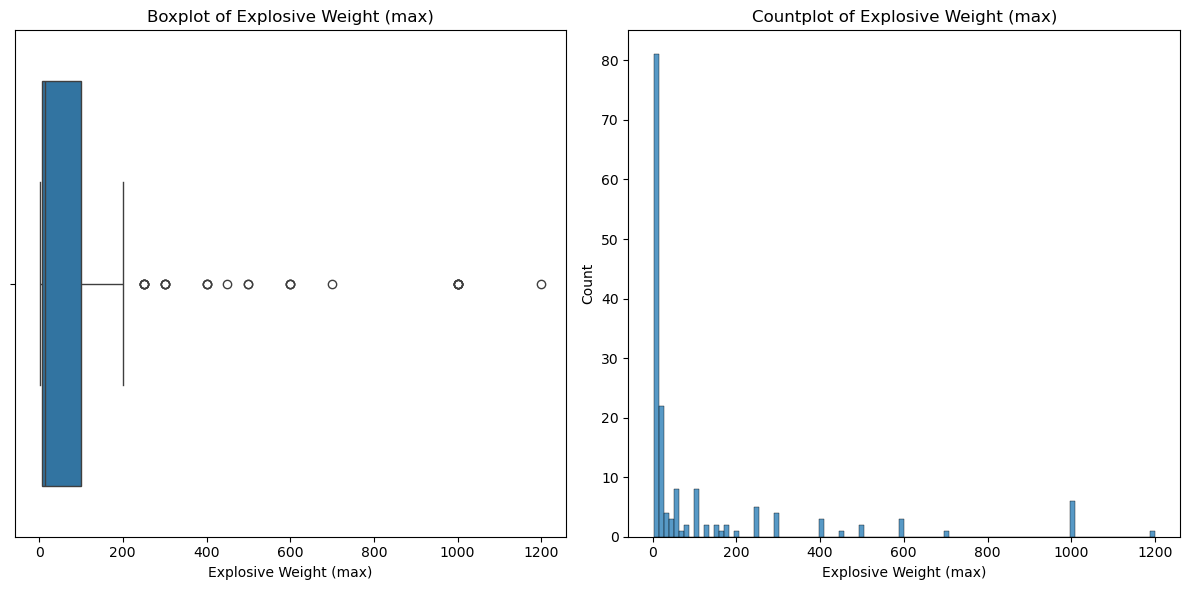

In [44]:
# Filter the dataset to include only values where 'Explosive Weight (max)' <= 200
df_plot = df[df['Explosive Weight (max)'] <= 200]

# Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the boxplot on the first axis (ax[0])
sns.boxplot(data=df, x='Explosive Weight (max)', ax=ax[0])
ax[0].set_title('Boxplot of Explosive Weight (max)')

# Plot the value counts as a barplot on the second axis (ax[1])
sns.histplot(data=df, x='Explosive Weight (max)',bins=100, ax=ax[1])
ax[1].set_title('Countplot of Explosive Weight (max)')

# Set the x-axis limits for the countplot (optional)
#x[1].set_xlim(0, 200)  # Setting x-axis limits
#ax[1].set_xticks(range(0, 201, 10))  # Setting x-ticks at intervals of 5

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [45]:
cleaned_file = os.path.join(CLEAN_DATA_DIR, 'cleaned_file.csv')
df.to_csv(cleaned_file)

## Results

1. **Missing Values**  
   As no specific requests were made to clean the database, no rows were removed. 
   - Missing values were imputed where possible, based on the values of other columns. For instance, geographic location data for cities was used to impute missing values, and Fahrenheit temperatures were imputed based on the corresponding Celsius values.

2. **Standardisation**  
   Most of the columns were of type `string`, and their values were standardised. This included:
   - Addressing issues like capitalisation inconsistencies and variations in input formatting (e.g., "Police/Rangers" was standardised to "Police").
   - Correcting common typographical errors and removing unnecessary whitespace characters.

3. **Validation**  
   Some values required validation. For example, the categorisation of "Weekend day" or "Weekday" was validated according to the corresponding **date value**.

4. **String to Numeric**  
   Where applicable, string values were converted to numeric values. This was done for columns where the values were clearly numeric but stored as strings.

5. **Columns with High Cardinality**  
   Columns with a large number of unique values were not altered. These columns were retained as they were to preserve their information.




In [46]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   S#                       492 non-null    int64  
 1   Date                     492 non-null    object 
 2   Islamic Date             336 non-null    object 
 3   Blast Day Type           481 non-null    object 
 4   Holiday Type             72 non-null     object 
 5   Time                     281 non-null    object 
 6   City                     492 non-null    object 
 7   Latitude                 490 non-null    float64
 8   Longitude                490 non-null    object 
 9   Province                 492 non-null    object 
 10  Location                 489 non-null    object 
 11  Location Category        457 non-null    object 
 12  Location Sensitivity     456 non-null    object 
 13  Open/Closed Space        457 non-null    object 
 14  Influencing Event/Event  1

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   S#                       492 non-null    int64         
 1   Date                     492 non-null    datetime64[ns]
 2   Islamic Date             336 non-null    object        
 3   Blast Day Type           492 non-null    category      
 4   Holiday Type             72 non-null     category      
 5   Time                     278 non-null    datetime64[ns]
 6   City                     492 non-null    category      
 7   Latitude                 492 non-null    float64       
 8   Longitude                492 non-null    float64       
 9   Province                 492 non-null    category      
 10  Location                 489 non-null    object        
 11  Location Category        456 non-null    category      
 12  Location Sensitivity     456 non-nul

In [48]:
df.describe(include= ['category'])

,Blast Day Type,Holiday Type,City,Province,Location Category,Location Sensitivity,Open/Closed Space,Target Type,Targeted Sect if any
count,492,72,492,492,456,456,456,465,97
unique,3,13,61,6,18,3,2,11,6
top,Working Day,General Holiday,peshawar,kpk,Police,high,open,Military,Shiite
freq,350,45,74,323,90,264,329,117,47


In [49]:
df.describe(include= ['object'])

,Islamic Date,Location,Influencing Event/Event,Hospital Names
count,336,489,187,294
unique,301,483,169,236
top,5 Rajab 1428 A.H,Imambargah,Sectarian strife,Lady Reading Hospital
freq,3,3,7,20


In [50]:
df.describe()

,S#,Date,Time,Latitude,Longitude,Killed Min,Killed Max,Injured Min,Injured Max,No. of Suicide Blasts,Explosive Weight (max),Temperature(C),Temperature(F)
count,492.000000,492,278,492.000000,492.000000,346.0,476.0,361.0,457.0,410.0,163.000000,487.000000,487.000000
mean,246.500000,2010-10-04 11:07:19.024390144,2025-03-11 13:20:35.827338240,32.614739,71.009446,14.855491,15.30042,31.601108,39.673961,1.117073,115.397546,21.075554,69.928113
min,1.000000,1995-11-19 00:00:00,2025-03-11 00:00:00,24.879503,62.350000,0.0,0.0,0.0,0.0,1.0,2.000000,-2.370000,27.734000
25%,123.750000,2008-10-05 06:00:00,2025-03-11 09:20:00,31.823800,70.145600,3.0,3.0,7.0,8.0,1.0,8.000000,14.617500,58.311500
50%,246.500000,2010-02-21 00:00:00,2025-03-11 12:45:00,33.583300,71.524900,8.0,8.0,20.0,23.0,1.0,14.000000,21.295000,70.331000
75%,369.250000,2013-01-15 12:00:00,2025-03-11 18:00:00,34.004300,72.425800,20.75,19.0,40.0,50.0,1.0,100.000000,28.115000,82.607000
max,492.000000,2017-10-05 00:00:00,2025-03-11 23:59:00,35.383300,74.572900,125.0,148.0,320.0,550.0,4.0,1200.000000,44.000000,111.000000
std,142.172431,NaN,NaN,2.475703,2.021881,17.659154,20.32867,38.762832,54.614206,0.396749,236.302936,8.390859,15.092688
